In [1]:
import pandas as pd
import numpy as np

import os
import sys
import time

# librosa is a Python library for analyzing audio and music.
#It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
# Paths for data.
Ravdess = "dataset/RAVDESS/"
Crema = "dataset/AudioWAV/"
Tess = "dataset/TESS-Toronto/TESS-Toronto/"
Savee = "dataset/ALL/"

In [3]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

Emotions                                               Path
0    angry  dataset/RAVDESS/Actor_16/03-01-05-01-02-01-16.wav
1     fear  dataset/RAVDESS/Actor_16/03-01-06-01-02-02-16.wav
2     fear  dataset/RAVDESS/Actor_16/03-01-06-02-01-02-16.wav
3    angry  dataset/RAVDESS/Actor_16/03-01-05-02-01-01-16.wav
4  disgust  dataset/RAVDESS/Actor_16/03-01-07-01-01-01-16.wav

In [4]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

Emotions                                  Path
0    angry  dataset/AudioWAV/1022_ITS_ANG_XX.wav
1    angry  dataset/AudioWAV/1037_ITS_ANG_XX.wav
2  neutral  dataset/AudioWAV/1060_ITS_NEU_XX.wav
3  neutral  dataset/AudioWAV/1075_ITS_NEU_XX.wav
4  disgust  dataset/AudioWAV/1073_IOM_DIS_XX.wav

In [5]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

Emotions                                               Path
0  disgust  dataset/TESS-Toronto/TESS-Toronto/YAF_disgust/...
1  disgust  dataset/TESS-Toronto/TESS-Toronto/YAF_disgust/...
2  disgust  dataset/TESS-Toronto/TESS-Toronto/YAF_disgust/...
3  disgust  dataset/TESS-Toronto/TESS-Toronto/YAF_disgust/...
4  disgust  dataset/TESS-Toronto/TESS-Toronto/YAF_disgust/...

In [6]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

Emotions                     Path
0       sad  dataset/ALL/JK_sa01.wav
1       sad  dataset/ALL/JK_sa15.wav
2   neutral   dataset/ALL/DC_n13.wav
3  surprise  dataset/ALL/DC_su09.wav
4   neutral   dataset/ALL/DC_n07.wav

In [7]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

Emotions                                               Path
0    angry  dataset/RAVDESS/Actor_16/03-01-05-01-02-01-16.wav
1     fear  dataset/RAVDESS/Actor_16/03-01-06-01-02-02-16.wav
2     fear  dataset/RAVDESS/Actor_16/03-01-06-02-01-02-16.wav
3    angry  dataset/RAVDESS/Actor_16/03-01-05-02-01-01-16.wav
4  disgust  dataset/RAVDESS/Actor_16/03-01-07-01-01-01-16.wav

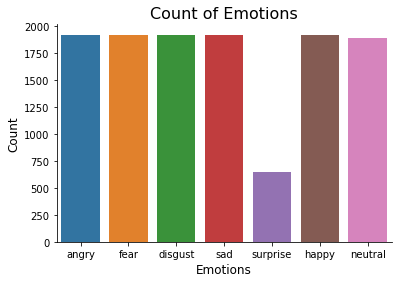

In [8]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [9]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

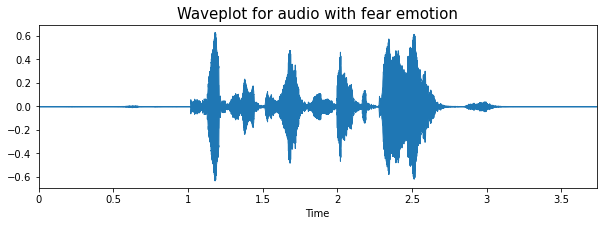

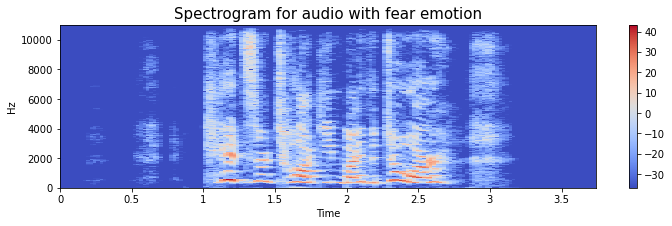

In [10]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

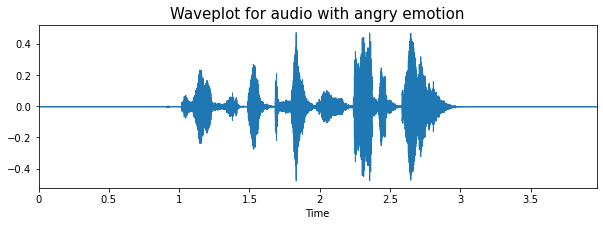

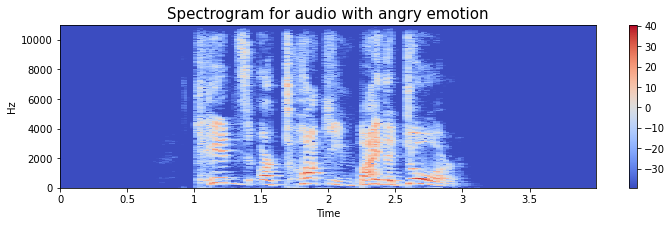

In [11]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

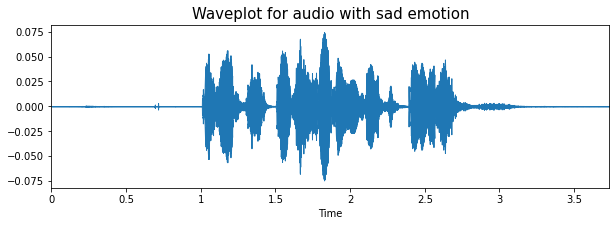

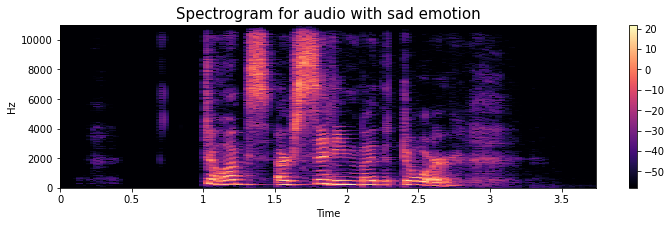

In [12]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

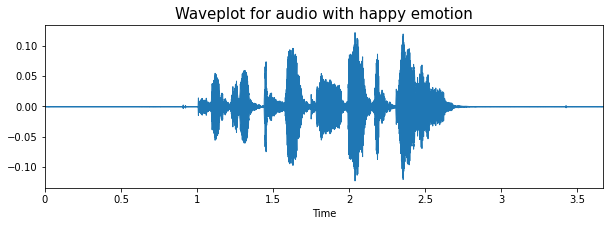

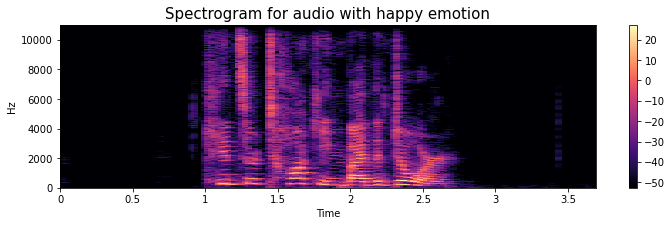

In [13]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [14]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

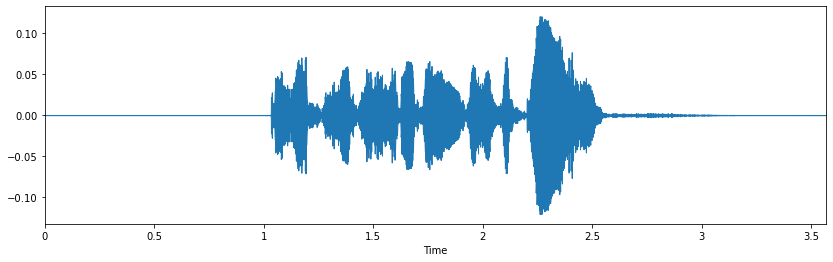

In [15]:
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=data, sr=sample_rate)
Audio(path)

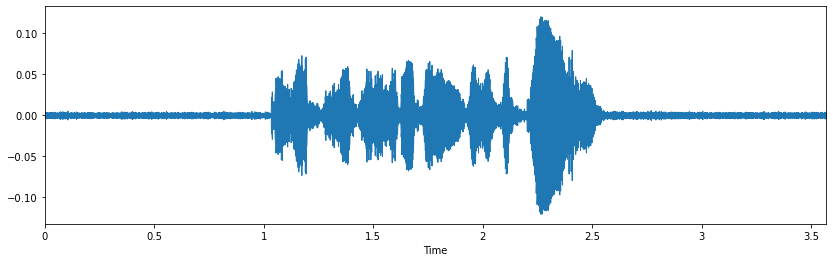

In [16]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

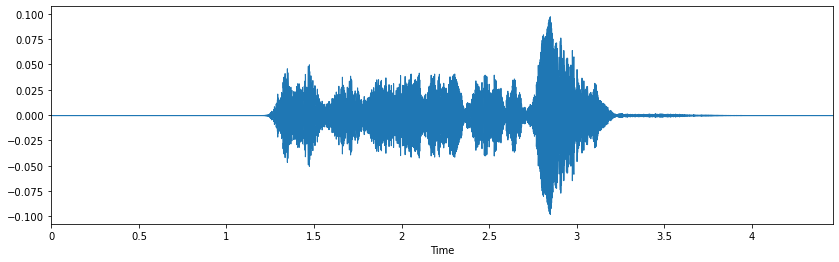

In [17]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

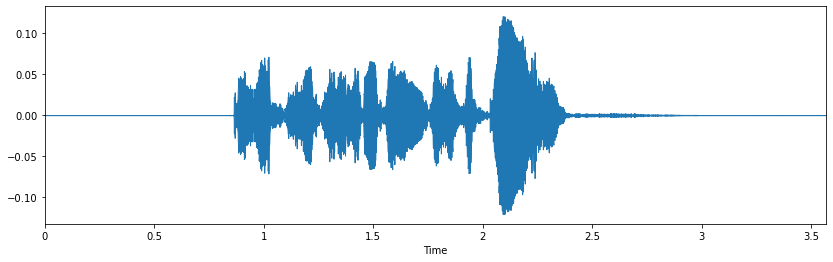

In [18]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

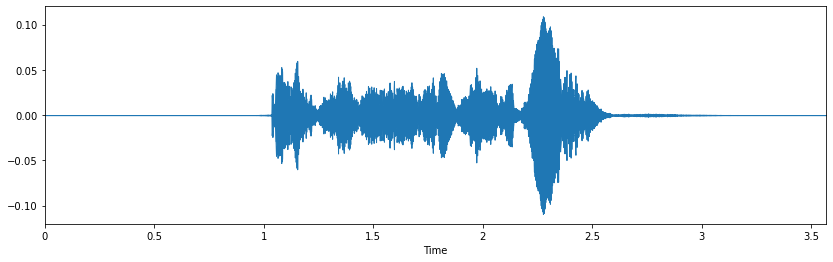

In [19]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

In [20]:
def extract_features(data):
    result = np.array([])
    
    # ZCR
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data,frame_length=2048,
                                                     hop_length=512,center=True).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate,
                                                      hop_length=512).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate,n_mfcc=13,
                                        hop_length=512).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data,hop_length=512).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate,
                                                 hop_length=512).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio
    #in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [21]:
%%time
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques
        #on each audio file.
        Y.append(emotion)

CPU times: user 1h 31min 40s, sys: 3min 42s, total: 1h 35min 23s
Wall time: 51min 22s


In [22]:
len(X), len(Y), data_path.Path.shape

(36486, 36486, (12162,))

In [24]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

0         1         2         3         4         5         6  \
0  0.197627  0.514769  0.462725  0.483974  0.550155  0.527827  0.602659   
1  0.338469  0.662289  0.677593  0.710698  0.698174  0.718393  0.644375   
2  0.222457  0.619763  0.514279  0.473754  0.490669  0.522670  0.509022   
3  0.187482  0.552680  0.513854  0.478974  0.428036  0.378610  0.395914   
4  0.324391  0.743496  0.757606  0.743217  0.727551  0.685715  0.638972   

          7         8         9  ...       146       147       148       149  \
0  0.542944  0.526867  0.601704  ...  0.006695  0.004046  0.004867  0.004637   
1  0.629818  0.689814  0.747915  ...  0.009278  0.006337  0.006997  0.006767   
2  0.613258  0.523150  0.546612  ...  0.003459  0.002275  0.000955  0.000806   
3  0.405448  0.433424  0.497569  ...  0.002606  0.002958  0.003861  0.003163   
4  0.587147  0.598434  0.617646  ...  0.003520  0.003792  0.004667  0.003915   

        150       151       152       153       154  labels  
0  0.005740  0.005929  0.004316  0.002451  0.000105   angry  
1  0.007916  0.008199  0.006340  0.004936  0.002445   angry  
2  0.000889  0.000870  0.001011  0.000293  0.000015   angry  
3  0.002973  0.002537  0.002107  0.000781  0.000050    fear  
4  0.003968  0.003342  0.002925  0.001557  0.000827    fear  

[5 rows x 156 columns]

In [26]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [27]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [28]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 155), (27364, 7), (9122, 155), (9122, 7))

In [29]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 155), (27364, 7), (9122, 155), (9122, 7))

In [30]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 155, 1), (27364, 7), (9122, 155, 1), (9122, 7))

In [31]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((20523, 155, 1), (20523, 7), (6841, 155, 1), (6841, 7))

In [32]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same',
                 activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=7, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 155, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 78, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 78, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 39, 256)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 39, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 20, 128)          0

In [33]:
%%time

rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50,
                  validation_data=(x_val, y_val), callbacks=[rlrp])

Epoch 1/50
321/321 [==============================] - 71s 218ms/step - loss: 1.7180 - accuracy: 0.2810 - val_loss: 1.5095 - val_accuracy: 0.3732 - lr: 0.0010
Epoch 2/50
321/321 [==============================] - 70s 219ms/step - loss: 1.5480 - accuracy: 0.3623 - val_loss: 1.4447 - val_accuracy: 0.4211 - lr: 0.0010
Epoch 3/50
321/321 [==============================] - 70s 217ms/step - loss: 1.4717 - accuracy: 0.3948 - val_loss: 1.3647 - val_accuracy: 0.4474 - lr: 0.0010
Epoch 4/50
321/321 [==============================] - 70s 219ms/step - loss: 1.3897 - accuracy: 0.4375 - val_loss: 1.3160 - val_accuracy: 0.4704 - lr: 0.0010
Epoch 5/50
321/321 [==============================] - 71s 221ms/step - loss: 1.3335 - accuracy: 0.4626 - val_loss: 1.2814 - val_accuracy: 0.4986 - lr: 0.0010
Epoch 6/50
321/321 [==============================] - 71s 221ms/step - loss: 1.2939 - accuracy: 0.4812 - val_loss: 1.2268 - val_accuracy: 0.5065 - lr: 0.0010
Epoch 7/50
321/321 [==============================] 

286/286 [==============================] - 7s 25ms/step - loss: 1.2070 - accuracy: 0.6043
Accuracy of our model on test data :  60.425347089767456 %


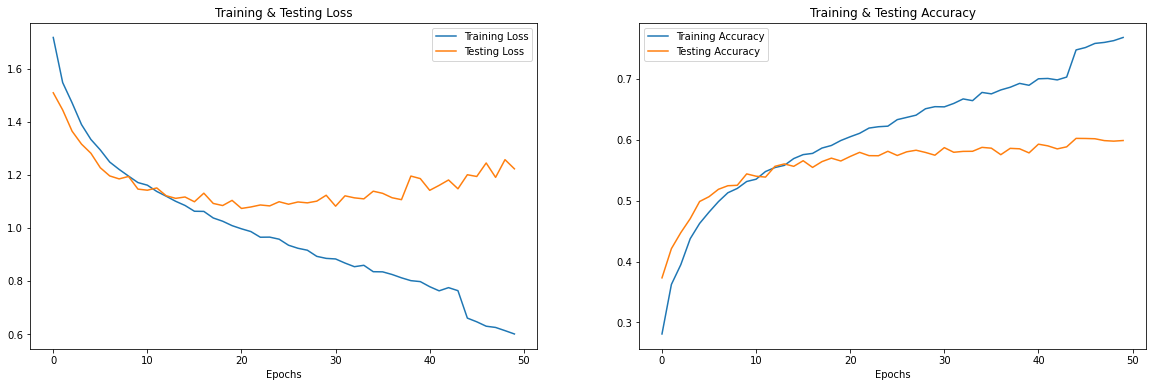

In [34]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [35]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

In [36]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels Actual Labels
0            angry         angry
1         surprise      surprise
2          disgust       disgust
3            angry         angry
4              sad           sad
5            angry         happy
6          neutral       neutral
7              sad           sad
8          neutral           sad
9             fear      surprise

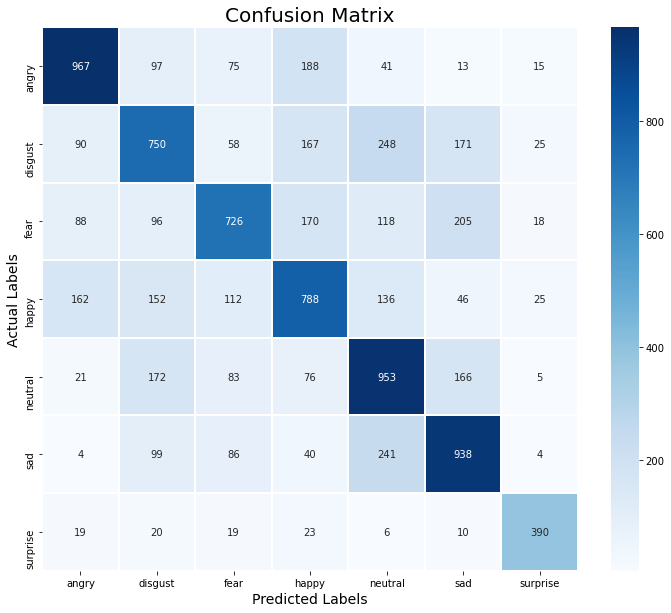

In [37]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_]
                  , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [38]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.72      0.69      0.70      1396
     disgust       0.54      0.50      0.52      1509
        fear       0.63      0.51      0.56      1421
       happy       0.54      0.55      0.55      1421
     neutral       0.55      0.65      0.59      1476
         sad       0.61      0.66      0.63      1412
    surprise       0.81      0.80      0.80       487

    accuracy                           0.60      9122
   macro avg       0.63      0.62      0.62      9122
weighted avg       0.61      0.60      0.60      9122



In [39]:
import sounddevice as sd 
from scipy.io.wavfile import write 
import wavio as wv 
from playsound import playsound 
import simpleaudio as sa

playsound is relying on a python 2 subprocess. Please use `pip3 install PyObjC` if you want playsound to run more efficiently.


In [40]:
freq = 44100 
   
# Recording duration 
duration = 5 
   
# Start recorder with the given values  
# of duration and sample frequency 
recording = sd.rec(int(duration * freq),  
                   samplerate=freq, channels=1) 
   
# Record audio for the given number of seconds 
sd.wait() 
   
# This will convert the NumPy array to an audio 
# file with the given sampling frequency 
write("recording0.wav", freq, recording) 
   
# Convert the NumPy array to audio file 
wv.write("recording1.wav", recording, freq, sampwidth=2)

In [ ]:
emotion='unknown' 
path = "recording1.wav" 
data, sampling_rate = librosa.load(path) 
create_waveplot(data, sampling_rate, emotion) 
create_spectrogram(data, sampling_rate, emotion) 
Audio(path)

In [ ]:
X1=[]

feature1 = get_features('recording1.wav') 
for ele in feature1: 
    X1.append(ele)
Features = pd.DataFrame(X1) 
Features.head()

In [ ]:
x = Features.values 
x_test1 = scaler.transform(x) 
x_test1 = np.expand_dims(x_test1, axis=2) 
# predicting on test data. 
pred_test1 = model.predict(x_test1) 
y_pred1 = encoder.inverse_transform(pred_test1)
y_pred1